<a href="https://colab.research.google.com/github/menguelx7/Diplodatos/blob/main/Series_de_Tiempo_en_Finanzas/Examen_Clase_1_y_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Series de tiempo en finanzas
### Entregable clase 1 y 2: Vale para media materia!!

Para aprobar hay que entregar Notebooks con la informacion pedida, comentada para su analisis. 

Notebook Clase 1:
Se pretende el entendimiento de la visualización y curación de una serie de tiempo. 

Notebook Clase 2:
Se pretende estudiar descomposiciones en tendencia, estacionalidad y proceso aleatorio. Usar suavizado exponenciar para predecir la serie de acuerdo a la descomposicion observada.



## Entregable clase 1:

### Exploración de la demanda eléctrica con Python

 ### Problema 1:
 
- Objetivo de este problema: La figura de boxplot de demanda de energía diaria muestra en forma equivocada el eje horario, por lo cual lleva a concluir que de noche la demanda de energia es maxima. Por lo cual es necesario corregirlo. 

- Una forma es modificar la figura, corrigiendo los ejes. Eso deja el resto de la notebook sin modificar (levemente... hay que pasar de dato cada 30 min a dato horario...). 

- La segunda es convertir la zona horaria a Australia/Victoria. Usando **pandas.Series.dt.tz** puede cambiar la zona horaria, como en el siguiente ejemplo



In [73]:
#ejemplo de código posible.... no chequeado para toda la notebook

#datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
#datos['Time'] = datos['Time'].dt.tz_localize('UTC')
#datos['Time'] = datos['Time'].dt.tz_convert('Australia/Victoria')
#datos = datos.set_index('Time')
#datos = datos.asfreq('30min')
#datos = datos.sort_index()

- Su tarea es corregir la zona horaria y correr TODA la notebook con esa corrección, verificando que no haya ambiguedades en las definiciones necesarias para plotear las estacionalidades mensuales y semanales. Como la cantidad de datos es muy grande, las estacionalidades se observan via boxplot.

# Desarrollo:

## Ejercicio 1 
Comenzaremos armando y presentando  el dataset, con el propósito de llegar a poner en evidencia dicho desfasaje de horarios que se está proponiento en el primer entregable. 

In [74]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Mediante Pandas leemos la base de datos original. Ya se sabe, de la primer clase, que esta base no cuenta con datos nulos.
La misma, tiene una columna la cual muestra en intervalos de 30 minutos la fecha y la hora a la cual se tomaron las mediciones de consumo electrico de la ciudad de Melburne. Lo que se hará a continuación, será a esta base de datos indexar la misma por un  índice cronológico. 

In [75]:
datos = pd.read_csv('https://raw.githubusercontent.com/menguelx7/Diplodatos/main/vic_elec.csv', sep=',')
datos

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True
...,...,...,...,...,...
52603,2014-12-31T10:30:00Z,3873.448714,19.00,2014-12-31,False
52604,2014-12-31T11:00:00Z,3791.637322,18.50,2014-12-31,False
52605,2014-12-31T11:30:00Z,3724.835666,17.70,2014-12-31,False
52606,2014-12-31T12:00:00Z,3761.886854,17.30,2014-12-31,False


In [76]:
datos_new=pd.read_csv('https://raw.githubusercontent.com/menguelx7/Diplodatos/main/vic_elec.csv', sep=',')

In [77]:
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()
datos


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True
...,...,...,...,...
2014-12-31 10:30:00,3873.448714,19.00,2014-12-31,False
2014-12-31 11:00:00,3791.637322,18.50,2014-12-31,False
2014-12-31 11:30:00,3724.835666,17.70,2014-12-31,False


Como se puede ver en la tabla anterior, la base de datos comienza en 2011 y finaliza en 2014. Tal como se menciona al comienzo de este entregable, el problema que se tiene es un desfasaje horario entre la hora local de Victoria, Australia y la GMT. Esto quiere decir que para ahorrar esfuerzos y para facilitar la observación de este problema, debemos tomar un pequeño tramo del dataset y presentarlo en escala horaria. 


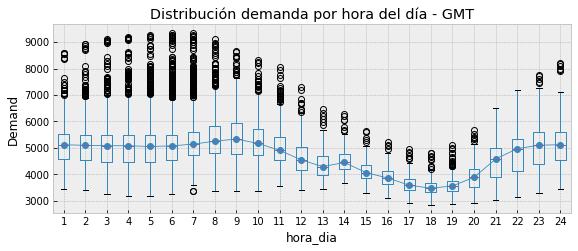

In [78]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día - GMT')
fig.suptitle('');

Es visible que la mayor demanda eléctrica se presenta durante  horas de madrugada, donde además se muestan una gran cantidad outliers. Esto nos da un alerta ya que, normalmente, la industria y los ciudadanos suelen ser más activos durante horas de la mañana y la tarno. 
Suponemos que el huso horario que se utilizó para las mediciones, no es el local sinó el estandar GMT +0. 
Veremos ahora de modificar el horario GMT al de Victoria, Australia. 

In [79]:
#Para trabajar con las dos bases de datos (con tiempo corregido y GMT) utilizaremos "datos_new" 
datos_new['Time'] = pd.to_datetime(datos_new['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos_new['Time'] = datos_new['Time'].dt.tz_localize('UTC')
datos_new['Time'] = datos_new['Time'].dt.tz_convert('Australia/Victoria')
datos_new = datos_new.set_index('Time')
datos_new = datos_new.asfreq('30min')
datos_new = datos_new.sort_index()

In [80]:
datos_new

,Demand,Temperature,Date,Holiday
Time,,,,
2012-01-01 00:00:00+11:00,4382.825174,21.40,2012-01-01,True
2012-01-01 00:30:00+11:00,4263.365526,21.05,2012-01-01,True
2012-01-01 01:00:00+11:00,4048.966046,20.70,2012-01-01,True
2012-01-01 01:30:00+11:00,3877.563330,20.55,2012-01-01,True
2012-01-01 02:00:00+11:00,4036.229746,20.40,2012-01-01,True
...,...,...,...,...
2014-12-31 21:30:00+11:00,3873.448714,19.00,2014-12-31,False
2014-12-31 22:00:00+11:00,3791.637322,18.50,2014-12-31,False
2014-12-31 22:30:00+11:00,3724.835666,17.70,2014-12-31,False


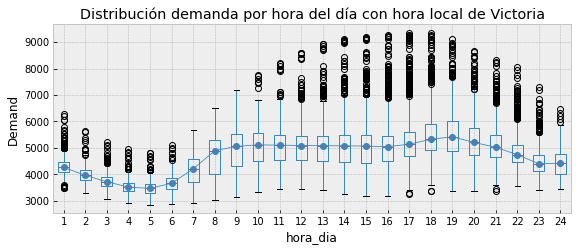

In [81]:
# Gráfico boxplot para estacionalidad diaria con hora de Victoria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos_new['hora_dia'] = datos_new.index.hour + 1
datos_new.boxplot(column='Demand', by='hora_dia', ax=ax)
datos_new.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día con hora local de Victoria')
fig.suptitle('');

Ahora, como vemos en la nueva gráfica, donde se desplazó el huso horario, podemos apreciar un consumo más acorde, donde los mínimos son durante horas de la madrugada y gradualmente comienzan a crecer en las primeras horas de la mañana hasta llegar a un máximo consumo eléctrico entre las 16 y las 18 h. 

Una vez solucionado este problema, continuaremos desarrollando la misma Notebook, presentada en durante la primera clase. Comenzaremos viendo la estacionalidad mensual y semanal: 

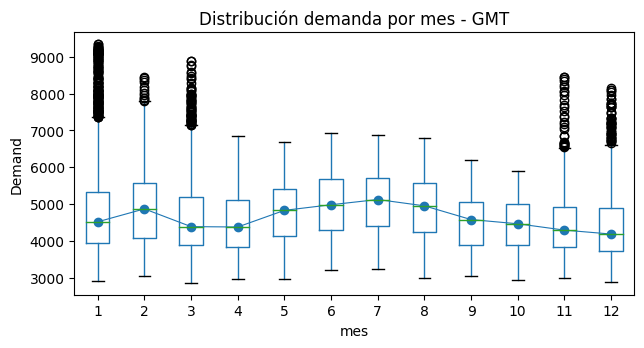

In [82]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
plt.style.use('default')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demand', by='mes', ax=ax,)
datos.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes - GMT')
fig.suptitle('');

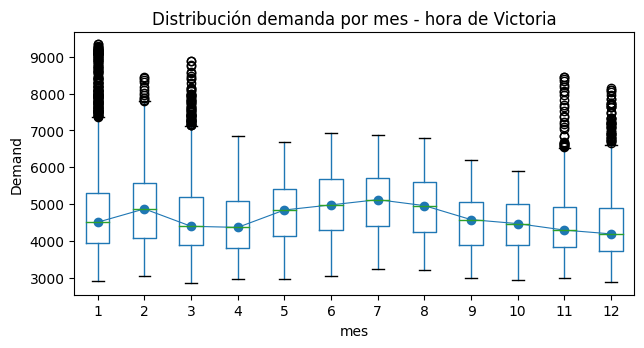

In [83]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
plt.style.use('default')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos_new['mes'] = datos_new.index.month
datos_new.boxplot(column='Demand', by='mes', ax=ax,)
datos_new.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes - hora de Victoria')
fig.suptitle('');

Viendo la distribución de la demanda de energia eléctrica, en el gráfico de cajas mes a mes, no se notaron cambios entre lasdos gráficas. 

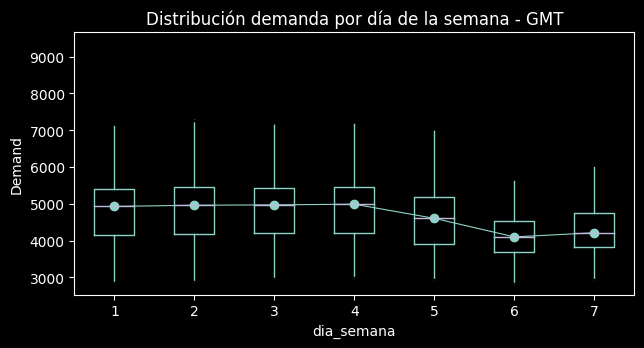

In [84]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['dia_semana'] = datos.index.day_of_week + 1
datos.boxplot(column='Demand', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana - GMT')
fig.suptitle('');

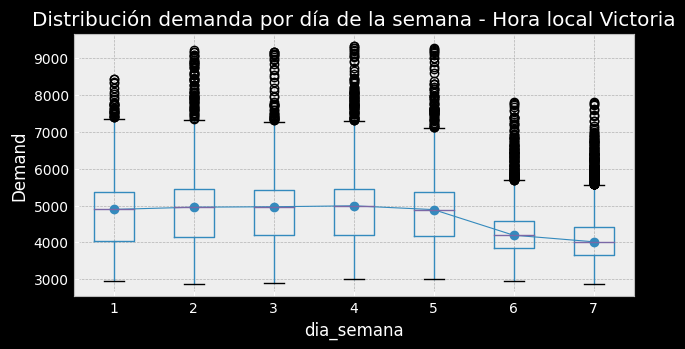

In [85]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos_new['dia_semana'] = datos_new.index.day_of_week + 1
datos_new.boxplot(column='Demand', by='dia_semana', ax=ax)
datos_new.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana - Hora local Victoria')
fig.suptitle('');

A diferencia de las gráficas intermensuales, en este caso se ve una ligera diferencia en la variación del consumo, notandose más entre los dias 5 y 7. Esto se puede deber al defasaje horario entre GMT y GMT+11, donde al haber 11 horas de diferencia, también se presenta un desfasaje de días.  

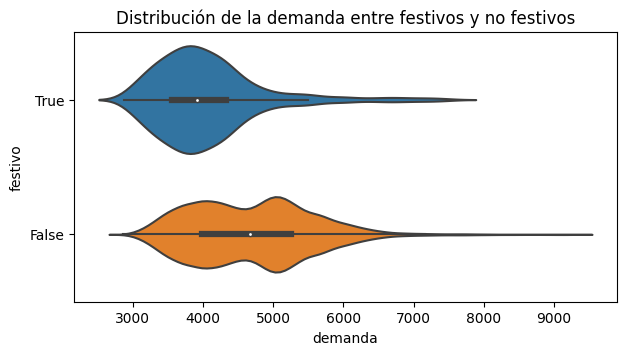

In [86]:
# Grafico violinplot
# ==============================================================================
plt.style.use('default')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos.assign(Holiday = datos.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

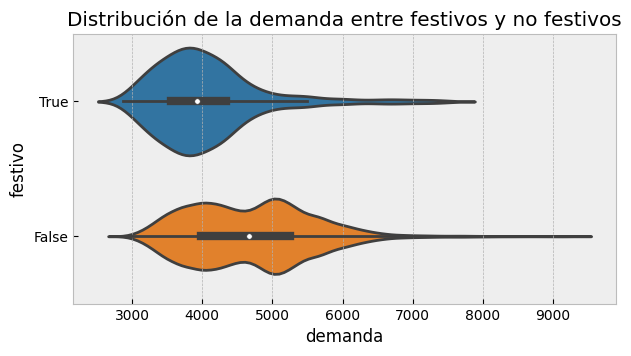

In [87]:
# Grafico violinplot
# ==============================================================================
plt.style.use('bmh')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos_new.assign(Holiday = datos_new.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

 # Ejercicio 2:
 
- Objetivo de este problema: Estudiar la demanda mensual. Realice gráficos siguiendo la notebook **Visualizacion de datos de polucion de corea.ipynb** realice 

- Gráfico de radar

- Gráfico de barra circular

- Gráfico de ploteo radial

Observe que Ud no tiene mas que una serie, por lo cual es como plotear para un solo distrito. 

In [88]:
datos_new

,Demand,Temperature,Date,Holiday,hora_dia,mes,dia_semana
Time,,,,,,,
2012-01-01 00:00:00+11:00,4382.825174,21.40,2012-01-01,True,1,1,7
2012-01-01 00:30:00+11:00,4263.365526,21.05,2012-01-01,True,1,1,7
2012-01-01 01:00:00+11:00,4048.966046,20.70,2012-01-01,True,2,1,7
2012-01-01 01:30:00+11:00,3877.563330,20.55,2012-01-01,True,2,1,7
2012-01-01 02:00:00+11:00,4036.229746,20.40,2012-01-01,True,3,1,7
...,...,...,...,...,...,...,...
2014-12-31 21:30:00+11:00,3873.448714,19.00,2014-12-31,False,22,12,3
2014-12-31 22:00:00+11:00,3791.637322,18.50,2014-12-31,False,23,12,3
2014-12-31 22:30:00+11:00,3724.835666,17.70,2014-12-31,False,23,12,3


In [89]:
#Agregamos una columna con años, ya que nos interesa poder ver año a año el consumo mensual 

In [90]:
datos_new['year'] = datos_new.index.year #Creamos una columna con el año
#datos_new['Month'] = datos_new.index.month



In [91]:
datos_new

,Demand,Temperature,Date,Holiday,hora_dia,mes,dia_semana,year
Time,,,,,,,,
2012-01-01 00:00:00+11:00,4382.825174,21.40,2012-01-01,True,1,1,7,2012
2012-01-01 00:30:00+11:00,4263.365526,21.05,2012-01-01,True,1,1,7,2012
2012-01-01 01:00:00+11:00,4048.966046,20.70,2012-01-01,True,2,1,7,2012
2012-01-01 01:30:00+11:00,3877.563330,20.55,2012-01-01,True,2,1,7,2012
2012-01-01 02:00:00+11:00,4036.229746,20.40,2012-01-01,True,3,1,7,2012
...,...,...,...,...,...,...,...,...
2014-12-31 21:30:00+11:00,3873.448714,19.00,2014-12-31,False,22,12,3,2014
2014-12-31 22:00:00+11:00,3791.637322,18.50,2014-12-31,False,23,12,3,2014
2014-12-31 22:30:00+11:00,3724.835666,17.70,2014-12-31,False,23,12,3,2014


In [92]:
datos_demand = datos_new['Demand'] #Creamos un dataset donde solo nos interesa la demanda 
datos_year = datos_new[datos_new.year==2012] #Hacemos un dataset con un año en específico. 
datos_year_mean = datos_year.groupby(datos_year['Demand'].index.month).mean()
datos_demand = datos_demand.groupby(datos_demand.index.month).mean()

In [93]:
#primero deberia probar con elegir un año, hacer un dataset de ese año, y recien hacer el gruop by
#otra opcion es usar el codigo de naqui groupby.mean()
year=2012
datos_year = datos_new[datos_new.year==year]


In [94]:
datos_year

,Demand,Temperature,Date,Holiday,hora_dia,mes,dia_semana,year
Time,,,,,,,,
2012-01-01 00:00:00+11:00,4382.825174,21.40,2012-01-01,True,1,1,7,2012
2012-01-01 00:30:00+11:00,4263.365526,21.05,2012-01-01,True,1,1,7,2012
2012-01-01 01:00:00+11:00,4048.966046,20.70,2012-01-01,True,2,1,7,2012
2012-01-01 01:30:00+11:00,3877.563330,20.55,2012-01-01,True,2,1,7,2012
2012-01-01 02:00:00+11:00,4036.229746,20.40,2012-01-01,True,3,1,7,2012
...,...,...,...,...,...,...,...,...
2012-12-31 21:30:00+11:00,3819.968190,18.40,2012-12-31,False,22,12,1,2012
2012-12-31 22:00:00+11:00,3747.193548,18.30,2012-12-31,False,23,12,1,2012
2012-12-31 22:30:00+11:00,3666.939868,18.00,2012-12-31,False,23,12,1,2012


In [95]:
datos_year_mean=datos_year_mean.astype(int)
import calendar
from calendar import month_name
datos_year_mean['mes'] = pd.to_datetime(datos_year_mean['mes'], format='%m').dt.month_name()
#A fin de mejorar la comprensión, se decidió reemplazar el número del mes, por su nombre.

In [96]:
datos_year_mean

,Demand,Temperature,Holiday,hora_dia,mes,dia_semana,year
Time,,,,,,,
1,4866,21,0,12,January,3,2012
2,4938,21,0,12,February,3,2012
3,4533,18,0,12,March,4,2012
4,4439,16,0,12,April,4,2012
5,4956,13,0,12,May,3,2012
6,5130,11,0,12,June,4,2012
7,5086,10,0,12,July,3,2012
8,5035,11,0,12,August,4,2012
9,4560,13,0,12,September,4,2012


In [97]:
list_demand = list(set(datos_year_mean['Demand']))

In [98]:
#months = list(reversed([str(i) for i in list(range(1,13))])) + ['12']
months = list(set(datos_year_mean['mes']))
month_lookup = list(month_name)
months = sorted(months, key=month_lookup.index) 
#Al armarse la lista, la misma queda desordenada por lo que era necesario darle un orden cronologico. 

In [99]:
months

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [100]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatterpolar(
  r=list_demand,
  theta=months,
  fill='toself'
))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)

fig.show()

# Circular Bar Plot

Comenzamos armando la función que permitirá realzar gráficos de barras radiales. Estas consisten en un grafico de barras normal pero distribuidas concentricamente a un círculo. Donde la longitud original de cada barra se ve traducida en el angulo alcanzado por cada semi circulo. 

Si bien esta gráfica puede resultar un tanto complicada de entender a primera vista, resulta llamativa o diferente al reto de graficos de barras, por lo que puede llamar la atención o despertar el interés de los espectadores. 

In [101]:

def get_color(name, number):
    pal = list(sns.color_palette(palette=name, n_colors=number).as_hex())
    return pal
def circular_bar(input_df, variable, column_name, title):
  pal_vi = get_color('Spectral', len(input_df))
  import math
  plt.gcf().set_size_inches(10, 10)
  ax = plt.subplot(projection='polar')
  input_df.reset_index(inplace=True, drop=True)
  ax.set_theta_zero_location('N')
  ax.set_theta_direction(1)
  ax.set_rlabel_position(0)
  ax.set_thetagrids([], labels=[])
  ax.set_rgrids(range(len(input_df)), labels= input_df[variable])
  ax = plt.subplot(projection='polar')
    
  for i in range(len(input_df)):
    ax.barh(i, input_df[column_name][i]*2*np.pi/max_val,
            label=input_df[variable][i], color=pal_vi[i])
  plt.title("Electric Demand MWh // " + title)
  plt.legend(bbox_to_anchor=(1, 1), loc=2)
  return ax

In [102]:
#Grafico de barra circular
max_val = max(datos_year_mean['Demand'])*1.01        #set max value
pal = list(sns.color_palette(palette='YlOrRd', n_colors=len(list_demand)).as_hex())

En este caso elegimos ver el consumo electrico y comparar mes a mes, para un año en particular. 

Cabe notar que la demanda máxima de energía eléctrica se produce entre los meses de mayo y agosto. 

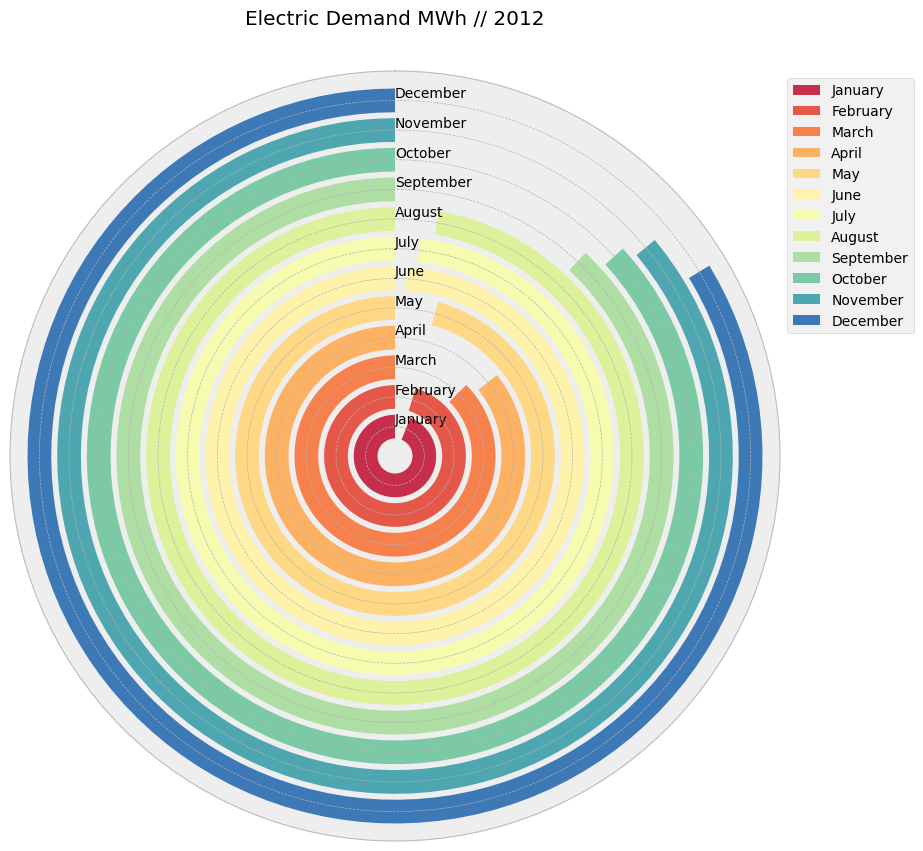

In [103]:
#list_month = months
#listdf_monthly = [datos_year_mean[datos_year_mean['mes']==str(i)] for i in list_month]

#keep_sname = []
#order = range(len(listdf_monthly))

circular_bar(datos_year_mean, 'mes', 'Demand', '2012')


In [104]:
#Grafico de ploteo radial 
#set color palette, lower and max values 
pal = list(sns.color_palette(palette='CMRmap_r', n_colors=len(datos_year_mean)).as_hex())
lowerLimit = 0
max_v = datos_year_mean['Demand'].max()

def radial_plot(input_df, variable,column_name, title):
    input_df.reset_index(inplace=True, drop=True)
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111, polar=True)
    plt.axis()

    heights = input_df[column_name]
    width = 2*np.pi / len(input_df.index)

    indexes = list(range(1, len(input_df.index)+1))
    angles = [element * width for element in indexes]

    bars = ax.bar(x=angles, height=heights, width=width, bottom=lowerLimit,
                  linewidth=1, edgecolor="white", color=pal)
    
    labelPadding = 2

    for bar, angle, height, label in zip(bars, angles, heights, input_df[variable]):
        rotation = np.rad2deg(angle)
        alignment = ""
      
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

        ax.text(x=angle, y=lowerLimit + bar.get_height() + labelPadding,
                s=label, ha=alignment, va='center', rotation=rotation, 
                rotation_mode="anchor")
    
        ax.set_thetagrids([], labels=[])
        plt.title("Demanda electrica mensual // " + title)
    return ax

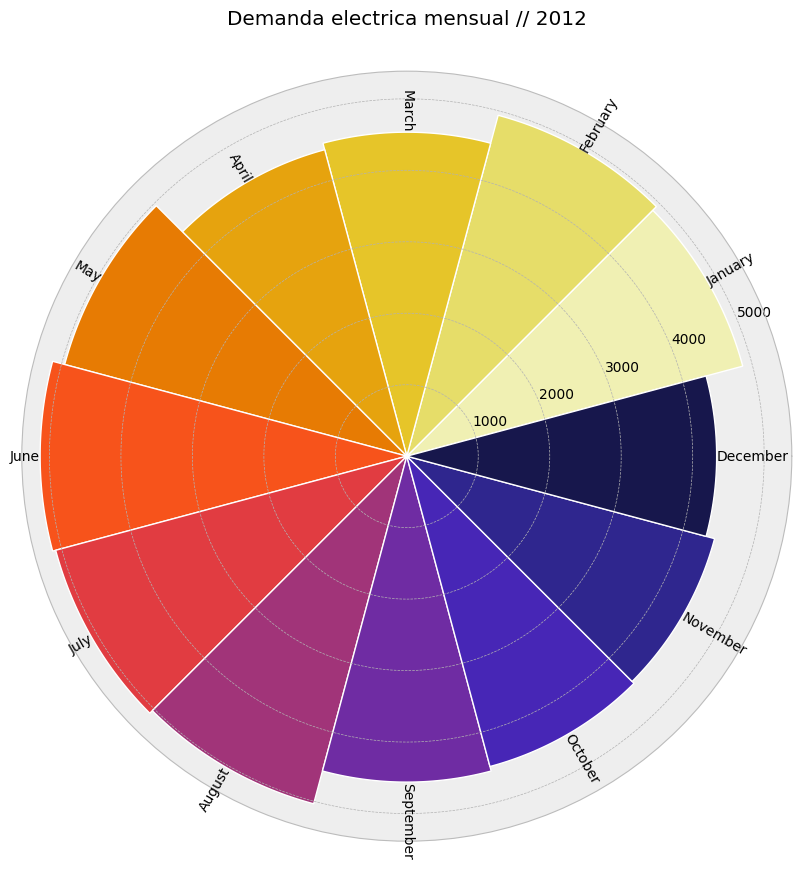

In [105]:
radial_plot(datos_year_mean, 'mes','Demand', '2012')

# Entregable clase 2:

### Exploración de la demanda eléctrica con Python

### Problema 1:
 
- Objetivo de este problema: Realizar descomposiciones en tendencia y estacionalidad de la serie original de demanda horaria,  de la serie de demanda mensual creada en el punto anterior y del zoom de demanda horaria ploteado.  Dar una opinion de lo observado.

A partir del trabajo presentado en clases: Comenzamos por vizualizar la información existente en la base de datos en cuestion

In [106]:
# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos['Time'] = datos['Time'].dt.tz_localize('UTC')
datos['Time'] = datos['Time'].dt.tz_convert('Australia/Victoria')



KeyError: ignored

### Problema 2:
 
- Objetivo de este problema: Realizar suavizado exponencial, suavizado de Holt y suavizado de Holt-Winter para las tres series anteriores y hacer una prediccion de 24 steps (un mes en el caso horario, un año en el caso mensual ). 

- Encontrar los parámetros usando el set de validación y RMSE. 

- Predecir usando TODA la serie (train mas validacion) y comparar con TEST . 

- Pltear la serie completa y la prediccion para observar el comportamiento de cada uno de los suavizados.

- Dar una opinion de la bondad del método para esta serie. 
